In [67]:
#WORKS: creating probabilistic assignments for the anatomical thalamus segmentations 

import numpy as np 
import ants 

wk_dir = '/Users/incehusain/fs_projects'

sub = 'sub-19'

segmentation_path = f"{wk_dir}/dseg_segmentations_Language7T/{sub}_thalamus_dseg.nii.gz"

template = f"{wk_dir}/tpl-MNI152NLin2009cSym_res-1_T1w.nii"

lut_file = f"{wk_dir}/compressionLookupTable.txt"

affine_transform_path = f"{wk_dir}/pseg_segmentations_Language7T/{sub}_to_MNI_0GenericAffine.mat"
warp_transform_path = f"{wk_dir}/pseg_segmentations_Language7T/{sub}_to_MNI_1Warp.nii.gz"
transform_list = [warp_transform_path, affine_transform_path]

lut_label_to_name = {}
with open(lut_file, 'r') as f:
    for line in f:
        if line.strip() and not line.startswith('#'):
            parts = line.strip().split()
            label = int(parts[0])
            name = parts[1]
            lut_label_to_name[label] = name
thalamus_labels = sorted(list(lut_label_to_name.keys()))

K = len(thalamus_labels)    

template_img = ants.image_read(template)
seg_img = ants.image_read(segmentation_path)

warped_prob_maps_list = []

for i, label in enumerate(thalamus_labels):
    print(f"Processing label {label} ({i+1}/{K})")
    mask_3d = (seg_img == label).astype('float32')
    warped_mask_3d = ants.apply_transforms(fixed=template_img, moving=mask_3d, transformlist=transform_list, interpolator='linear')
        
    warped_prob_maps_list.append(warped_mask_3d)

warped_prob_4d_img = ants.merge_channels(warped_prob_maps_list)

prob_array_kxp = warped_prob_4d_img.numpy()

#visualizing as a nii file 

output_5d_nii = f"{wk_dir}/{sub}_5d_thalamus_prob_map.nii.gz"

ants.image_write(warped_prob_4d_img, output_5d_nii)

#column_sums = prob_array_kxp.sum(axis=0) 
#thalamus_mask_1d = column_sums > 0

#thalamus_prob_map = prob_array_kxp[:, thalamus_mask_1d] 

#K=thalamus_prob_map.shape[0]
#P=thalamus_prob_map.shape[1]

#column_sums_final = thalamus_prob_map.sum(axis=0)
#column_sums_final[column_sums_final == 0] = 1

#final_prob_map = thalamus_prob_map / column_sums_final

#np.save(f"{wk_dir}/pseg_matrices_Language7T/{sub}_pseg_matrix.npy", final_prob_map)



Processing label 8103 (1/58)
Processing label 8104 (2/58)
Processing label 8105 (3/58)
Processing label 8106 (4/58)
Processing label 8108 (5/58)
Processing label 8109 (6/58)
Processing label 8110 (7/58)
Processing label 8111 (8/58)
Processing label 8112 (9/58)
Processing label 8113 (10/58)
Processing label 8115 (11/58)
Processing label 8116 (12/58)
Processing label 8117 (13/58)
Processing label 8118 (14/58)
Processing label 8119 (15/58)
Processing label 8120 (16/58)
Processing label 8121 (17/58)
Processing label 8122 (18/58)
Processing label 8123 (19/58)
Processing label 8125 (20/58)
Processing label 8126 (21/58)
Processing label 8127 (22/58)
Processing label 8128 (23/58)
Processing label 8129 (24/58)
Processing label 8130 (25/58)
Processing label 8133 (26/58)
Processing label 8134 (27/58)
Processing label 8135 (28/58)
Processing label 8136 (29/58)
Processing label 8203 (30/58)
Processing label 8204 (31/58)
Processing label 8205 (32/58)
Processing label 8206 (33/58)
Processing label 82

In [151]:
from nilearn.image import mean_img
import nibabel as nb

wk_dir = '/Users/incehusain/fs_projects/pseg_Language7T'

subject_file = [ 'sub-01_4d_thalamus_prob_map.nii.gz', 'sub-02_4d_thalamus_prob_map.nii.gz', 'sub-03_4d_thalamus_prob_map.nii.gz',
                    'sub-04_4d_thalamus_prob_map.nii.gz', 'sub-06_4d_thalamus_prob_map.nii.gz',
                    'sub-07_4d_thalamus_prob_map.nii.gz', 'sub-08_4d_thalamus_prob_map.nii.gz', 'sub-09_4d_thalamus_prob_map.nii.gz',
                    'sub-10_4d_thalamus_prob_map.nii.gz', 'sub-12_4d_thalamus_prob_map.nii.gz',
                    'sub-13_4d_thalamus_prob_map.nii.gz', 'sub-14_4d_thalamus_prob_map.nii.gz', 'sub-15_4d_thalamus_prob_map.nii.gz',
                    'sub-16_4d_thalamus_prob_map.nii.gz', 'sub-17_4d_thalamus_prob_map.nii.gz', 'sub-18_4d_thalamus_prob_map.nii.gz',
                    'sub-19_4d_thalamus_prob_map.nii.gz' ]

N=len(subject_file)

first_img = nb.load(f"{wk_dir}/{subject_file[0]}")

sum_of_data = first_img.get_fdata().astype('float64')

for i in range(1, N):
    img = nb.load(f"{wk_dir}/{subject_file[i]}")
    sum_of_data += img.get_fdata()

mean_data = sum_of_data / N

mean_img_nii = nb.Nifti1Image(mean_data.astype('float32'), first_img.affine, first_img.header)

nb.save(mean_img_nii, f"{wk_dir}/group_mean_thalamus_prob_map.nii.gz")

print("hey")

#group_map_img = mean_img([f"{wk_dir}/{f}" for f in subject_file])



KeyboardInterrupt: 

In [82]:
import nibabel as nb 
import numpy as np

sub = 'sub-19'

input_5d_nii = f"{wk_dir}/{sub}_5d_thalamus_prob_map.nii.gz"

output_4d_nii = f"{wk_dir}/{sub}_4d_thalamus_prob_map.nii.gz"

img_5d = nb.load(input_5d_nii)

data_5d = img_5d.get_fdata()    

data_4d_real = np.squeeze(data_5d)

new_img_4d = nb.Nifti1Image(data_4d_real, img_5d.affine)

nb.save(new_img_4d, output_4d_nii)


In [156]:
wk_dir = '/Users/incehusain/fs_projects/pseg_Language7T'
sub = 'sub-01'

output_4d_nii = f"{wk_dir}/5d_files/{sub}_5d_thalamus_prob_map.nii.gz"

individ_data = nb.load(output_4d_nii)

individual_prob_map = individ_data.get_fdata()

print("hey")

KeyboardInterrupt: 

In [ ]:
#creating KxP hard assignment matrix for the anatomical thalamus segmentations

import Functional_Fusion.atlas_map as am
import HierarchBayesParcel.arrangements as ar
import nibabel as  nb
import numpy as np
import torch as pt

wk_dir = '/Users/incehusain/fs_projects'
iglesias_atlas_nii = f"{wk_dir}/dseg_segmentations_Language7T/sub_19_thalamus_dseg.nii.gz"
lut_file = f"{wk_dir}/compressionLookupTable.txt"
iglesias_head = '# Labels for thalamus parcellation using histological atlas (Iglesias et al.)'
lut_label_to_name = {}

with open(lut_file, 'r') as f:
    for line in f:
        if line.strip() and not line.startswith('#'):
            parts = line.strip().split()
            label = int(parts[0])
            name = parts[1]
            lut_label_to_name[label] = name

thalamus_labels = sorted(list(lut_label_to_name.keys()))

K = len(thalamus_labels)

img = nb.load(iglesias_atlas_nii)

data = img.get_fdata().astype(np.int32)

thalamus_voxel = data > 0

voxel_labels = data[thalamus_voxel]

P=len(voxel_labels)
#we are no longer reading it into MNISymThalamus1 space - going to make new ROI mask using anatomical images
#atlas, _ = am.get_atlas('MNISymThalamus1')
#U = atlas.read_data(iglesias_atlas_nii)
#P=U.shape[0]


label_to_index = {label: idx for idx, label in enumerate(thalamus_labels)}

prob_map_numpy = np.zeros((K, P))

for p, label in enumerate(voxel_labels):
    if label in label_to_index:
        k = label_to_index[label]
        prob_map_numpy[k, p] = 1.0

U_iglesias = np.array(prob_map_numpy)

U_iglesias_map = np.round(U_iglesias)
#ar_model = ar.build_arrangement_model(U_iglesias_map, prior_type='prob', atlas=atlas)
#print("TEST")


In [22]:
#Registering segmentations to MNI125NLin2009cSym 

import ants 
import os

wk_dir = '/Users/incehusain/fs_projects'

sub = 'sub-19'

output_prefix = f"{wk_dir}/pseg_segmentations_Language7T/{sub}_to_MNI_"

template = f"{wk_dir}/tpl-MNI152NLin2009cSym_res-1_T1w.nii"
T1_nii = f"{wk_dir}/freesurfer_Language7T/{sub}/mri/T1.mgz"   #or norm.mgz

seg_nii = f"{wk_dir}/dseg_segmentations_Language7T/{sub}_thalamus_dseg.nii.gz"

output_path = f"{wk_dir}"

template_ants = ants.image_read(template)
T1 = ants.image_read(T1_nii)
seg = ants.image_read(seg_nii)

print('Registering...')

registration = ants.registration(fixed=template_ants, moving=T1, type_of_transform='SyN', outprefix=output_prefix)

print('Registration done!')

warped_seg = ants.apply_transforms(fixed=template_ants, moving=seg, transformlist=registration['fwdtransforms'], interpolator='linear')

ants.image_write(warped_seg, f"{wk_dir}/pseg_segmentations_Language7T/{sub}_seg_warped.nii.gz")



Registering...
Registration done!


In [155]:
wk_dir = '/Users/incehusain/fs_projects'

thalamus_map_sub1 = np.load(f"{wk_dir}/pseg_matrices_Language7T/sub-01_pseg_matrix.npy")
thalamus_map_sub2 = np.load(f"{wk_dir}/pseg_matrices_Language7T/sub-02_pseg_matrix.npy")
thalamus_map_sub3 = np.load(f"{wk_dir}/pseg_matrices_Language7T/sub-04_pseg_matrix.npy")

print(thalamus_map_sub1.shape)

print(thalamus_map_sub2.shape)

print(thalamus_map_sub3[0].shape)


(58, 25064)
(58, 22172)


KeyboardInterrupt: 

In [88]:
#thresholding thalamus mask

import nibabel as nb
import numpy as np

thalamus_mask = '/Users/incehusain/fs_projects/thalamus_mask.nii'
img = nb.load(thalamus_mask)
data = img.get_fdata()

threshold = 0.004

binary_mask = (data >= threshold).astype(np.uint8)

binary_mask_img = nb.Nifti1Image(binary_mask, img.affine, img.header)

nb.save(binary_mask_img, '/Users/incehusain/fs_projects/thalamus_mask_thresholded_025.nii')




In [359]:
#generating Vs

import Functional_Fusion.dataset as ds
import numpy as np
import nibabel as nb
import Functional_Fusion.atlas_map as am
import torch as pt
import HierarchBayesParcel.util as ut

subj = 'sub-09'

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion_new' 
wk_dir = '/Users/incehusain/fs_projects'

data, info, ds_obj = ds.get_dataset(base_dir,'Language',atlas='MNISymThalamus1', 
                                    sess='ses-localizerfm', 
                                    subj=[subj], 
                                    type='CondAll')

#for CondRun: get shape (num_coditions, num_voxels) by averaging over runs for each condition 

#info['unique_conditions']= info['task_code'].astype(str) + '_' + info['cond_code'].astype(str)
#unique_conditions = info['unique_conditions'].unique().tolist()
#num_conditions = len(unique_conditions) 
#num_voxels = data[0].shape[1]

#data_cond_all = np.zeros((num_conditions, num_voxels))  

#for i, cond in enumerate(unique_conditions):    
 #   cond_mask = info['unique_conditions'] == cond
  #  data_cond_all[i, :] = data[0][cond_mask, :].mean(axis=0)

#read probabilistic maps in thalamus ROI space and normalize
    
atlas, _ = am.get_atlas('MNISymThalamus1')

pseg_data_4d = nb.load(f"{wk_dir}/pseg_Language7T/{subj}_4d_thalamus_prob_map.nii.gz")
pseg_data_read = atlas.read_data(pseg_data_4d)

group = nb.load(f"{wk_dir}/pseg_Language7T/group_mean_thalamus_prob_map.nii.gz")
group_data_read = atlas.read_data(group)

column_sums_subj = pseg_data_read.sum(axis=0)
column_sums_subj[column_sums_subj == 0] = 1
pseg_norm = pseg_data_read / column_sums_subj 

column_sums_group = group_data_read.sum(axis=0)    
column_sums_group[column_sums_group == 0] = 1
group_norm = group_data_read / column_sums_group 

#weighted average of data using normalized subject or group probability maps 

Vs_subj = data[0] @ pseg_data_read.T
Vs_group = data[0] @ group_data_read.T

parcel_weight_sums_subj = pseg_data_read.sum(axis=1)
parcel_weight_sums_subj[parcel_weight_sums_subj == 0] = 1
Vs_subj_avg = Vs_subj / parcel_weight_sums_subj  

parcel_weight_sums_group = group_data_read.sum(axis=1)
parcel_weight_sums_group[parcel_weight_sums_group == 0] = 1
Vs_group_avg = Vs_group / parcel_weight_sums_group

pt.save(Vs_subj_avg,f"{wk_dir}/V_matrices/V_subj_{subj}_unnorm.pt")
pt.save(Vs_group_avg,f"{wk_dir}/V_matrices/V_group_{subj}_unnorm.pt")

#normalize the V vectors 

col_norms = np.linalg.norm(Vs_subj_avg, axis=0)
col_norms[col_norms == 0] = 1
Vs_subj_normalized = Vs_subj_avg / col_norms

col_norms_group = np.linalg.norm(Vs_group_avg, axis=0)  
col_norms_group[col_norms_group == 0] = 1   
Vs_group_normalized = Vs_group_avg / col_norms_group

pt.save(Vs_subj_normalized,f"{wk_dir}/V_matrices/V_subj_{subj}_norm.pt")
pt.save(Vs_group_normalized,f"{wk_dir}/V_matrices/V_group_{subj}_norm.pt")


/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_50491/2418883626.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  V_Social = pt.load(f"{wk_dir}/V_matrices_Soc

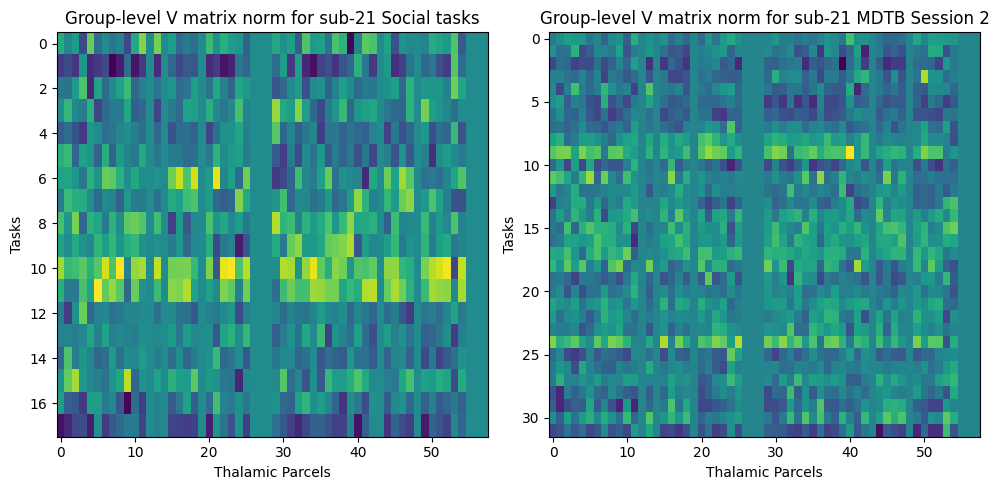

In [74]:
#V vector visualization

import torch as pt
import numpy as np
import matplotlib.pyplot as plt

wk_dir = '/Users/incehusain/fs_projects'
subj = 'sub-21'

V_Social = pt.load(f"{wk_dir}/V_matrices_Social/V_group_{subj}_norm.pt")
V_mdtb_ses2 = pt.load(f"{wk_dir}/V_matrices_MDTB_ses2/V_group_{subj}_norm.pt")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

im_subj = axs[0].imshow(V_Social, aspect='auto', cmap='viridis')    
axs[0].set_title(f'Group-level V matrix norm for {subj} Social tasks')
axs[0].set_xlabel('Thalamic Parcels')
axs[0].set_ylabel('Tasks')
#fig.colorbar(im_subj, ax=axs[0],label='Normalized activation level')

im_group = axs[1].imshow(V_mdtb_ses2, aspect='auto', cmap='viridis') 
axs[1].set_title(f'Group-level V matrix norm for {subj} MDTB Session 2')
axs[1].set_xlabel('Thalamic Parcels')
axs[1].set_ylabel('Tasks')


plt.tight_layout()  
plt.show()  


/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_50491/898519630.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Social_parcel = pt.load(f"{wk_dir}/cosine_sim

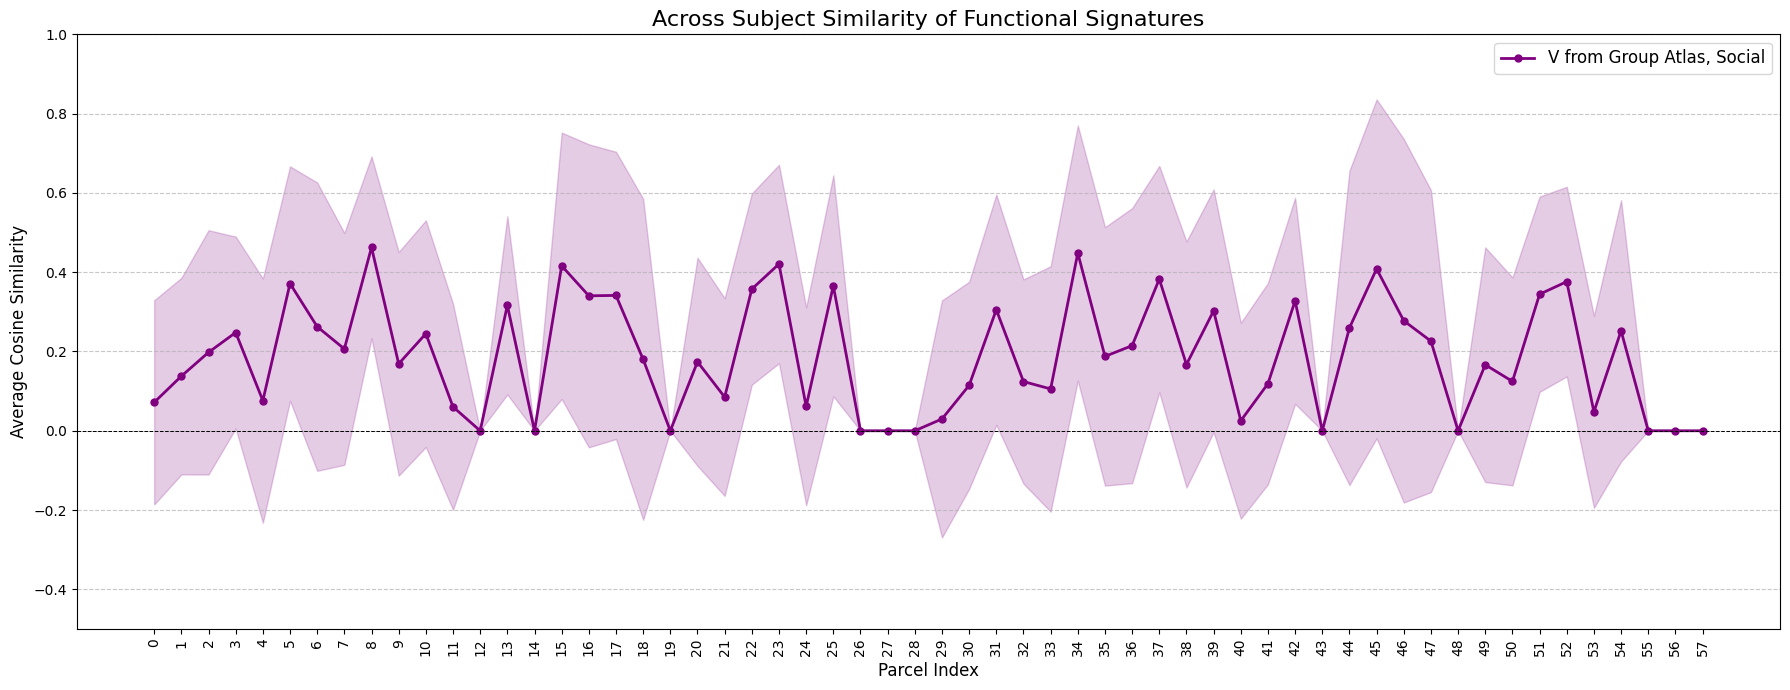

In [77]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats


wk_dir = '/Users/incehusain/fs_projects'

Social_parcel = pt.load(f"{wk_dir}/cosine_similarities_Social/cosine_parcels_group.pt")
#mdtb_ses2_parcel = pt.load(f"{wk_dir}/cosine_similarities_MDTB/cosine_parcels_group_MDTB_ses2.pt")

mean_Social = np.array([arr.mean() for arr in Social_parcel])  
#mean_mdtb_ses2 = np.array([arr.mean() for arr in mdtb_ses2_parcel])

std_mdtb_ses1 = np.array([arr.std() for arr in Social_parcel])
#std_mdtb_ses2 = np.array([arr.std() for arr in mdtb_ses2_parcel])

num_parcels = len(Social_parcel)   
parcel_indices = np.arange(num_parcels)


fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(parcel_indices, mean_Social, 'o-', label='V from Group Atlas, Social', color='purple', linewidth=2, markersize=5)
ax.fill_between(parcel_indices, mean_Social - std_mdtb_ses1, mean_Social + std_mdtb_ses1, color='purple', alpha=0.2)

#ax.plot(parcel_indices, mean_mdtb_ses2, 'o-', label='V from Group Atlas, MDTB-Ses2', color='skyblue', linewidth=2, markersize=5)
#ax.fill_between(parcel_indices, mean_mdtb_ses2 - std_mdtb_ses2, mean_mdtb_ses2 + std_mdtb_ses2, color='skyblue', alpha=0.2)

ax.set_title('Across Subject Similarity of Functional Signatures', fontsize=16)
ax.set_xlabel('Parcel Index', fontsize=12)
ax.set_ylabel('Average Cosine Similarity', fontsize=12)
ax.set_xticks(parcel_indices)
if num_parcels > 30:
    ax.tick_params(axis='x', labelrotation=90) 

ax.set_ylim(-0.5, 1)

ax.axhline(0, color='black', linestyle='--', linewidth=0.7)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#t_stat, p_value = stats.ttest_rel(mean_Social, mean_mdtb_ses2)   
#print(f"T-statistic: {t_stat}, P-value: {p_value}")

/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_50491/246694514.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Social = pt.load(f"{wk_dir}/cosine_similaritie

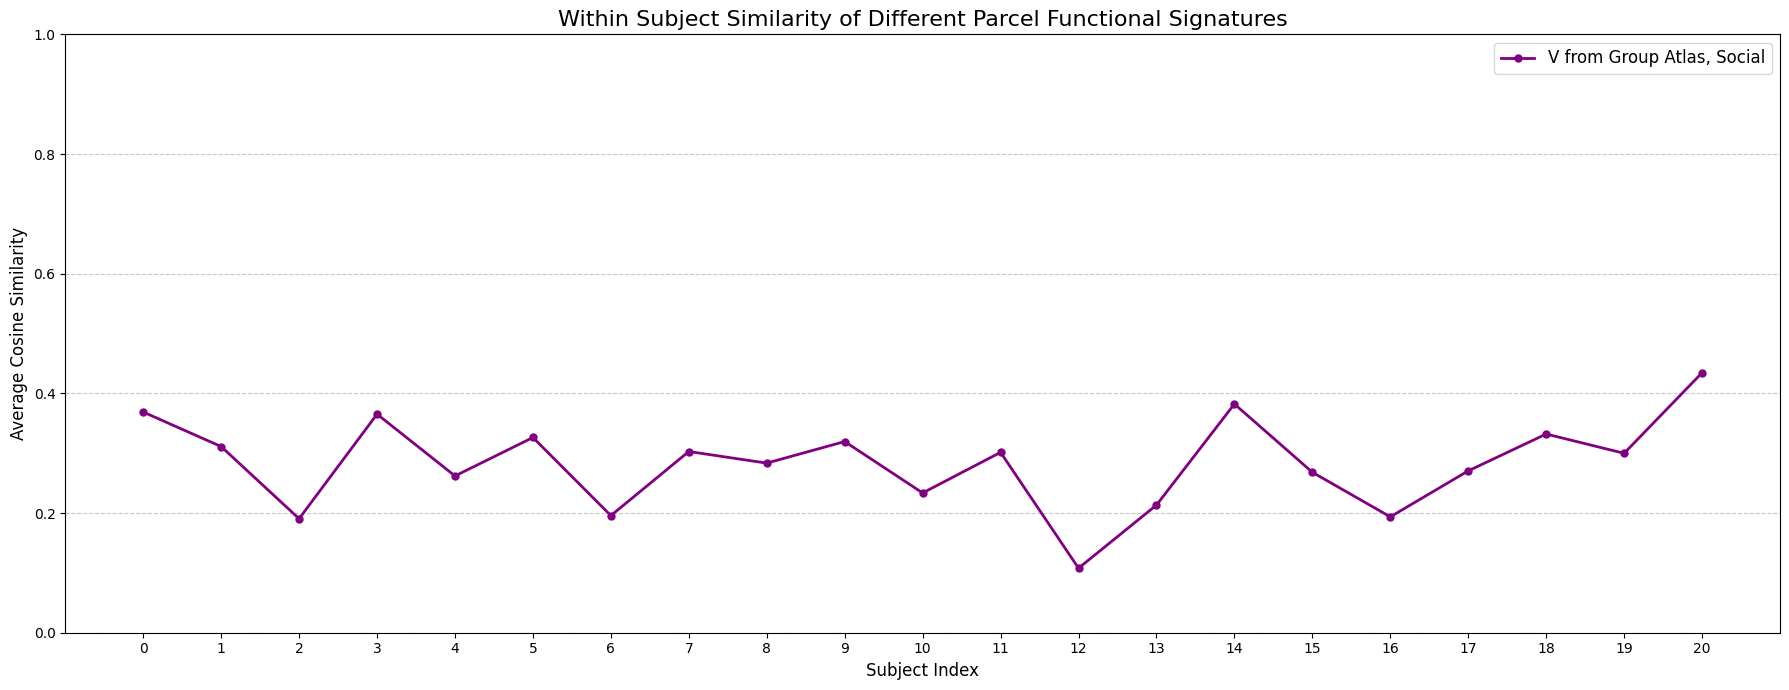

In [78]:
import torch as pt
import numpy as np
import matplotlib.pyplot as plt

wk_dir = '/Users/incehusain/fs_projects'

Social = pt.load(f"{wk_dir}/cosine_similarities_Social/cosine_within_subj_groupV.pt")
#mdtb_ses2 = pt.load(f"{wk_dir}/cosine_similarities_MDTB/cosine_within_subj_groupV_mdtb_ses2.pt")

num_parcels = len(Social)   
parcel_indices = np.arange(num_parcels)

fig, ax = plt.subplots(figsize=(18, 7))

ax.plot(parcel_indices, Social, 'o-', label='V from Group Atlas, Social', color='purple', linewidth=2, markersize=5)
#ax.fill_between(parcel_indices, mean_indiv - std_indiv, mean_indiv + std_indiv, color='purple', alpha=0.2)

#ax.plot(parcel_indices, mdtb_ses2, 'o-', label='V from Group Atlas, MDTB-ses2', color='skyblue', linewidth=2, markersize=5)
#ax.fill_between(parcel_indices, mean_group - std_group, mean_group + std_group, color='skyblue', alpha=0.2)

ax.set_title('Within Subject Similarity of Different Parcel Functional Signatures', fontsize=16)
ax.set_xlabel('Subject Index', fontsize=12)
ax.set_ylabel('Average Cosine Similarity', fontsize=12)
ax.set_xticks(parcel_indices)
if num_parcels > 30:
    ax.tick_params(axis='x', labelrotation=90) 

ax.set_ylim(0, 1)

ax.axhline(0, color='black', linestyle='--', linewidth=0.7)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



/var/folders/91/7fqn4cp541g41hf5rkxmsnhh0000gn/T/ipykernel_50491/4015149282.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  avg_all_parcels = pt.load(f"{wk_dir}/cosine_s

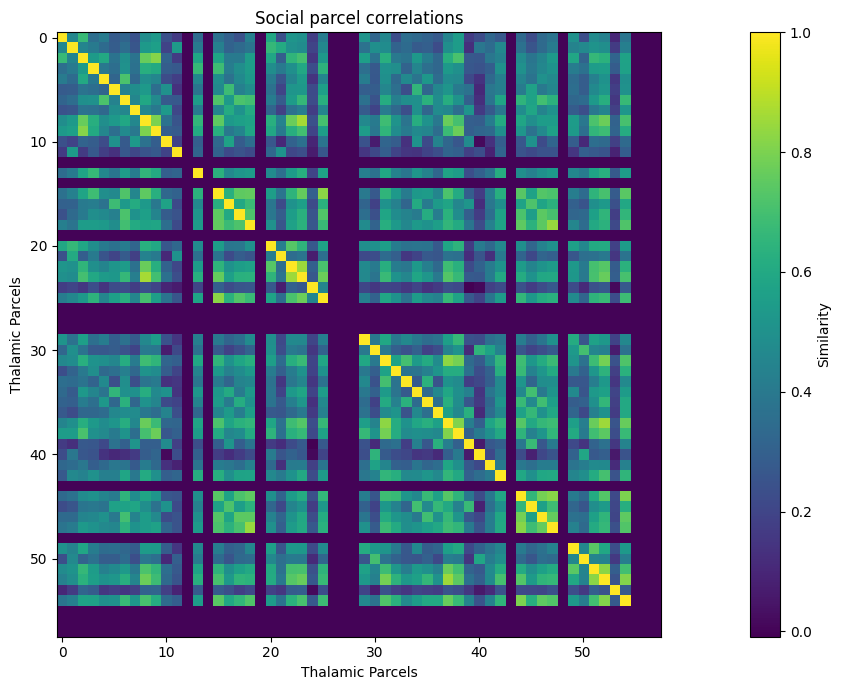

In [79]:
#parcel correlations visualization 

import torch as pt
import numpy as np
import matplotlib.pyplot as plt

wk_dir = '/Users/incehusain/fs_projects'

avg_all_parcels = pt.load(f"{wk_dir}/cosine_similarities_Social/cosine_avg_all_parcels.pt")

num_parcels = avg_all_parcels.shape[0]  
parcel_indices = np.arange(num_parcels) 

fig, ax = plt.subplots(figsize=(18, 7))

im = ax.imshow(avg_all_parcels, cmap='viridis', vmin=np.min(avg_all_parcels), vmax=1)

ax.set_title(f'Social parcel correlations')
ax.set_xlabel('Thalamic Parcels')
ax.set_ylabel('Thalamic Parcels')

fig.colorbar(im, ax=ax,label='Similarity')

plt.tight_layout()  
plt.show()  


In [65]:
#extracting datasets

import Functional_Fusion.dataset as ds

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion_new'


dataset = ds.DataSetSocial(base_dir + '/Social')
dataset.extract_all(ses_id='ses-social',
                    type='CondAll',
                    atlas='MNISymThalamus1')




Atlasmap sub-03
Extract sub-03
Atlasmap sub-04
Extract sub-04
Atlasmap sub-05
Extract sub-05
Atlasmap sub-07
Extract sub-07
Atlasmap sub-08
Extract sub-08
Atlasmap sub-09
Extract sub-09
Atlasmap sub-10
Extract sub-10
Atlasmap sub-11
Extract sub-11
Atlasmap sub-12
Extract sub-12
Atlasmap sub-13
Extract sub-13
Atlasmap sub-14
Extract sub-14
Atlasmap sub-16
Extract sub-16
Atlasmap sub-17
Extract sub-17
Atlasmap sub-18
Extract sub-18
Atlasmap sub-19
Extract sub-19
Atlasmap sub-20
Extract sub-20
Atlasmap sub-21
Extract sub-21
Atlasmap sub-22
Extract sub-22
Atlasmap sub-24
Extract sub-24
Atlasmap sub-25
Extract sub-25
Atlasmap sub-26
Extract sub-26
Atlasmap sub-27
Extract sub-27


In [61]:
import SUITPy.normalization as suit_norm
import ants

wk_dir = '/Users/incehusain/fs_projects'

source_file = f"{wk_dir}/xfm_files/Social/sub-04_T1w.nii"
mask_file = f"{wk_dir}/xfm_files/Social/sub-04_desc-cereb_mask_new.nii"

#source_img = ants.image_read(source_file)
#mask_img = ants.image_read(mask_file)

#mask_fixed = ants.copy_image_info(source_img, mask_img)
#mask_new = ants.resample_image_to_target(mask_img, source_img, interp_type='nearestNeighbor')

#mask_new.shape == source_img.shape
#mask_new.spacing == source_img.spacing
#mask_new.origin == source_img.origin
#mask_new.direction == source_img.direction

#mask_new.to_filename(f"{wk_dir}/xfm_files/Social/sub-04_desc-cereb_mask_new.nii")
#ants.image_write(mask_new, f"{wk_dir}/xfm_files/Social/sub-04_desc-cereb_mask_new.nii")

deformation_file = suit_norm.normalize(source_file, mask_file, space='MNISym')

template_file = f"{wk_dir}/tpl-MNI152NLin2009cSym_res-1_T1w.nii"
displacement_file = f"{wk_dir}/xfm_files/Social/sub-04_T1w_to-MNISym_mode-image_xfm.nii.gz"
deformation_file_name = f"{wk_dir}/xfm_files/Social/sub-04_space-MNI152NLin2009cSym_xfm.nii.gz"

new_deformation_file = suit_norm.deformation_from_displacement(template_file, displacement_file, deformation_file_name)

print("hey")

Normalizing sub-04_T1w to tpl-MNI152NLin2009cSymC_T1w.nii.gz
Saving the normalized image into sub-04_T1w_space-MNISym.nii.gz
Saving deformation field into sub-04_T1w_to-MNISym_mode-image_xfm.nii.gz


KeyboardInterrupt: 